# Code to Test HierProb3D's PyTorch3D Rendering
For usage from within Docker container:
1. Start docker container on host with argument `-p 8888:8888`
2. From within docker:
    - Install jupyter notebook: `pip install notebook`
    - Start jupyter notebook: `jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`
3. On the host visit `localhost:8888/tree`

## Autoreload
Automatically reloads files that have changed

In [1]:
%load_ext autoreload
%autoreload 2

## Verbosity Settings
0 - silent; 1 - important only; 2 - everything

In [2]:
verbosity = 2

## Necessary Imports

In [193]:
import os
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if verbosity > 0:
    print(f"Torch {torch.__version__}")
    if torch.cuda.is_available():
        print("CUDA available")
    else:
        print("CUDA unavailable")
    print(f"Device: {device}")
import sys
sys.path.append('/garmentor')
from data.on_the_fly_smpl_train_dataset import OnTheFlySMPLTrainDataset
from configs import paths
from configs.poseMF_shapeGaussian_net_config import get_poseMF_shapeGaussian_cfg_defaults
from renderers.pytorch3d_textured_renderer import TexturedIUVRenderer
import pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex, TexturesUV
if verbosity > 0:
    print(f"PyTorch3D {pytorch3d.__version__}")
from models.smpl_official import SMPL
from smplx.lbs import batch_rodrigues
from utils.augmentation.smpl_augmentation import normal_sample_shape
from utils.augmentation.cam_augmentation import augment_cam_t
from utils.augmentation.proxy_rep_augmentation import augment_proxy_representation, random_extreme_crop
from utils.augmentation.rgb_augmentation import augment_rgb
from utils.augmentation.lighting_augmentation import augment_light
from utils.label_conversions import ALL_JOINTS_TO_H36M_MAP, ALL_JOINTS_TO_COCO_MAP, H36M_TO_J14
from utils.rigid_transform_utils import aa_rotate_rotmats_pytorch3d, aa_rotate_translate_points_pytorch3d
from utils.cam_utils import perspective_project_torch
from utils.joints2d_utils import check_joints2d_visibility_torch
import numpy as np
import matplotlib.pyplot as plt

Torch 1.11.0
CUDA available
Device: cuda:0
PyTorch3D 0.6.2


## Load Configuration

In [4]:
pose_shape_cfg = get_poseMF_shapeGaussian_cfg_defaults()
if verbosity > 1:
    print(f"Configuration: \n{pose_shape_cfg}")

Configuration: 
DATA:
  BBOX_SCALE_FACTOR: 1.2
  BBOX_THRESHOLD: 0.95
  EDGE_GAUSSIAN_SIZE: 5
  EDGE_GAUSSIAN_STD: 1.0
  EDGE_NMS: True
  EDGE_THRESHOLD: 0.0
  HEATMAP_GAUSSIAN_STD: 4.0
  PROXY_REP_SIZE: 256
LOSS:
  NUM_SAMPLES: 8
  SAMPLE_ON_CPU: True
  STAGE1:
    J2D_LOSS_ON: means
    MF_OVERREG: 1.005
    REDUCTION: mean
    WEIGHTS:
      GLOB_ROTMATS: 5000.0
      JOINTS2D: 5000.0
      JOINTS3D: 0.0
      POSE: 80.0
      SHAPE: 50.0
      VERTS3D: 0.0
  STAGE2:
    J2D_LOSS_ON: means+samples
    MF_OVERREG: 1.005
    REDUCTION: mean
    WEIGHTS:
      GLOB_ROTMATS: 5000.0
      JOINTS2D: 30000.0
      JOINTS3D: 5000.0
      POSE: 10.0
      SHAPE: 80.0
      VERTS3D: 5000.0
  STAGE_CHANGE_EPOCH: 66
MODEL:
  DELTA_I: True
  DELTA_I_WEIGHT: 1.0
  EMBED_DIM: 256
  NUM_IN_CHANNELS: 18
  NUM_RESNET_LAYERS: 18
  NUM_SMPL_BETAS: 10
TRAIN:
  BATCH_SIZE: 4
  EPOCHS_PER_SAVE: 5
  LR: 0.0001
  NUM_EPOCHS: 300
  NUM_WORKERS: 2
  PIN_MEMORY: True
  SYNTH_DATA:
    AUGMENT:
      BBOX:
    

## Some Default Tensors

In [5]:
x_axis = torch.tensor([1., 0., 0.], device=device, dtype=torch.float32)
delta_betas_std_vector = torch.ones(
    pose_shape_cfg.MODEL.NUM_SMPL_BETAS,
    device=device,
    dtype=torch.float32
) * pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.SMPL.SHAPE_STD
mean_shape = torch.zeros(
    pose_shape_cfg.MODEL.NUM_SMPL_BETAS,
    device=device,
    dtype=torch.float32
)
mean_cam_t = torch.tensor(
    pose_shape_cfg.TRAIN.SYNTH_DATA.MEAN_CAM_T,
    device=device,
    dtype=torch.float32
)
mean_cam_t = mean_cam_t[None, :].expand(pose_shape_cfg.TRAIN.BATCH_SIZE, -1)

tensor([ 0.0000, -0.2000,  2.5000], device='cuda:0')


## Load Train and Validation Datasets

In [6]:
train_dataset = OnTheFlySMPLTrainDataset(
    poses_path=paths.TRAIN_POSES_PATH,
    textures_path=paths.TRAIN_TEXTURES_PATH,
    backgrounds_dir_path=paths.TRAIN_BACKGROUNDS_PATH,
    params_from='not_amass',
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)

val_dataset = OnTheFlySMPLTrainDataset(
    poses_path=paths.VAL_POSES_PATH,
    textures_path=paths.VAL_TEXTURES_PATH,
    backgrounds_dir_path=paths.VAL_BACKGROUNDS_PATH,
    params_from='all',
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)
if verbosity > 0:
    print("Training:")
    print(f"    Poses found: {len(train_dataset)}")
    print(f"    Textures found (gray / non-gray): {len(train_dataset.grey_textures)} / {len(train_dataset.nongrey_textures)}")
    print(f"    Backgrounds found: {len(train_dataset.backgrounds_paths)}")
    print("Validation:")
    print(f"    Poses found: {len(val_dataset)}")
    print(f"    Textures found (gray / non-gray): {len(val_dataset.grey_textures)} / {len(val_dataset.nongrey_textures)}")
    print(f"    Backgrounds found: {len(val_dataset.backgrounds_paths)}")

Training:
    Poses found: 91106
    Textures found (gray / non-gray): 125 / 792
    Backgrounds found: 99414
Validation:
    Poses found: 33347
    Textures found (gray / non-gray): 32 / 76
    Backgrounds found: 3000


## Train and Validation Data Loaders

In [7]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=pose_shape_cfg.TRAIN.NUM_WORKERS,
    pin_memory=pose_shape_cfg.TRAIN.PIN_MEMORY
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=pose_shape_cfg.TRAIN.NUM_WORKERS,
    pin_memory=pose_shape_cfg.TRAIN.PIN_MEMORY
)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

## Initialize PyTorch3D Renderer

In [156]:
pytorch3d_renderer = TexturedIUVRenderer(
    device=device,
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE,
    projection_type='perspective',
    perspective_focal_length=pose_shape_cfg.TRAIN.SYNTH_DATA.FOCAL_LENGTH,
    render_rgb=True,
    bin_size=32
)

pytorch3d_textured_renderer.TexturedIUVRenderer.__init__::verts_iuv: 
tensor([[[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.6983e-01],
         [1.0000e+00, 2.5478e-02, 7.4877e-01],
         [1.0000e+00, 2.2805e-01, 7.5733e-01],
         ...,
         [2.4000e+01, 5.5260e-01, 4.8146e-01],
         [2.4000e+01, 5.4398e-01, 4.8146e-01],
         [2.4000e+01, 2.7596e-03, 6.4889e-01]],

        [[1.0000e+00, 2.7660e-02, 7.

## Initialize SMPL model

In [9]:
smpl_model = SMPL(paths.SMPL, num_betas=pose_shape_cfg.MODEL.NUM_SMPL_BETAS).to(device)

## Fetch Training Data

In [60]:
for batch in train_dataloader:
    target_poses = batch['pose'].to(device)
    backgrounds = batch['background'].to(device)
    textures = batch['texture'].to(device)
    if verbosity > 0:
        print(f"Poses shape: {target_poses.shape}")
        print(f"Backgrounds shape: {backgrounds.shape}")
        print(f"Textures shape: {textures.shape}")
    break
# Randomly sample body shape
target_shapes = normal_sample_shape(
    batch_size=pose_shape_cfg.TRAIN.BATCH_SIZE,
    mean_shape=mean_shape,
    std_vector=delta_betas_std_vector
)
# Randomly sample camera translation
target_cam_t = augment_cam_t(
    mean_cam_t,
    xy_std=pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.CAM.XY_STD,
    delta_z_range=pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.CAM.DELTA_Z_RANGE
)
if verbosity > 0:
    print(f"Shapes shape: {target_shapes.shape}")
    print(f"Camera translation shape: {target_cam_t.shape}")

Poses shape: torch.Size([4, 72])
Backgrounds shape: torch.Size([4, 3, 256, 256])
Textures shape: torch.Size([4, 1200, 800, 3])
Shapes shape: torch.Size([4, 10])
Camera translation shape: torch.Size([4, 3])


## Visualize the Batch

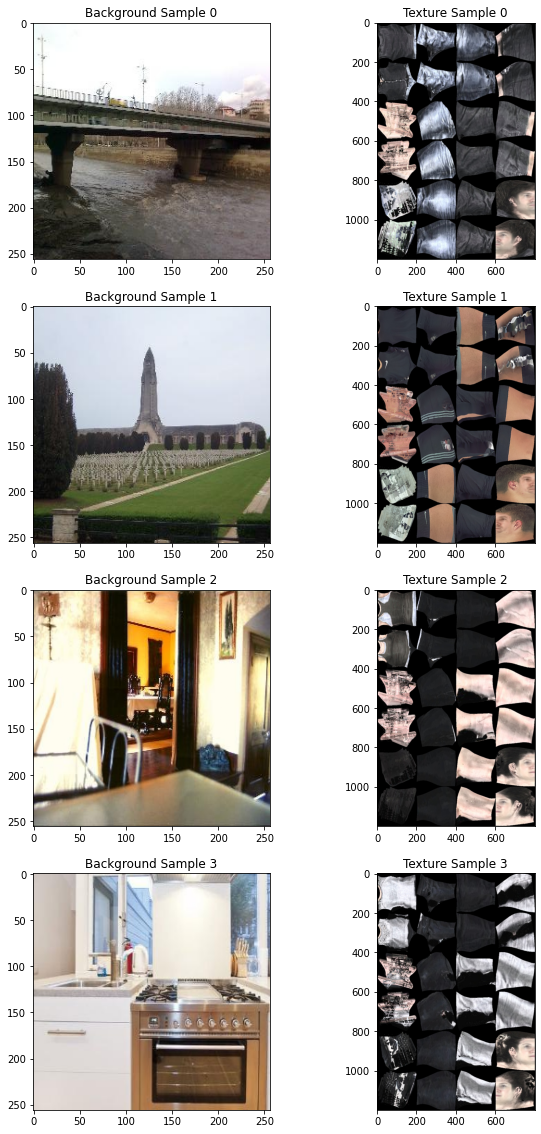

In [67]:
if verbosity > 1:
    batch_size = batch['pose'].shape[0]
    fig, axs = plt.subplots(batch_size, 2, figsize=(10,20))
    for idx in range(batch_size):
        axs[idx, 0].imshow(backgrounds[idx].permute(1,2,0).cpu())
        axs[idx, 1].imshow(textures[idx].cpu())
        axs[idx, 0].set_title(f"Background Sample {idx}")
        axs[idx, 1].set_title(f"Texture Sample {idx}")
    fig.show()

## Convert Axis-Angle Representation to Rotation Matrices

In [11]:
target_poses_rotmats = batch_rodrigues(target_poses.contiguous().view(-1, 3)).view(-1, 24, 3, 3)
# first entry is global orientation
target_glob_rotmats = target_poses_rotmats[:, 0, :, :]
target_poses_rotmats = target_poses_rotmats[:, 1:, :, :]
if verbosity > 1:
    print(f"Poses rotation matrices: {target_poses_rotmats.shape}")
    print(f"Global rotation matrix: {target_glob_rotmats.shape}")

Poses rotation matrices: torch.Size([4, 23, 3, 3])
Global rotation matrix: torch.Size([4, 3, 3])


## Flip Pose Targets such that they are right way up in 3D space
Flipping pose targets such that they are right way up in 3D space - i.e. wrong way up when projected <br>
Then pose predictions will also be right way up in 3D space - network doesn't need to learn to flip.

In [12]:
_, target_glob_rotmats = aa_rotate_rotmats_pytorch3d(
    rotmats=target_glob_rotmats,
    angles=np.pi,
    axes=x_axis,
    rot_mult_order='post'
)

## Compute Target Vertices and Joints

In [18]:
target_smpl_output = smpl_model(
    body_pose=target_poses_rotmats,
    global_orient=target_glob_rotmats.unsqueeze(1),
    betas=target_shapes,
    pose2rot=False
)
target_vertices = target_smpl_output.vertices
target_joints_all = target_smpl_output.joints
target_joints_h36m = target_joints_all[:, ALL_JOINTS_TO_H36M_MAP, :]
target_joints_h36mlsp = target_joints_h36m[:, H36M_TO_J14, :]
if verbosity > 1:
    print(f"Vertices: {target_vertices.shape}")
    print(f"All joints: {target_joints_all.shape}")
    print(f"Human3.6M joints: {target_joints_h36m.shape}")
    print(f"Human3.6M LSP joints: {target_joints_h36mlsp.shape}")
    
target_reposed_vertices = smpl_model(
    body_pose=torch.zeros_like(target_poses)[:, 3:], # Removes global orientation
    global_orient=torch.zeros_like(target_poses)[:, :3],
    betas=target_shapes    
).vertices
if verbosity > 1:
    print(f"Reposed vertices: {target_reposed_vertices.shape}")

Vertices: torch.Size([4, 6890, 3])
All joints: torch.Size([4, 90, 3])
Human3.6M joints: torch.Size([4, 17, 3])
Human3.6M LSP joints: torch.Size([4, 14, 3])
Reposed vertices: torch.Size([4, 6890, 3])


## Prepare Data for Rendering
Pose targets were flipped such that they are right way up in 3D space - i.e. wrong way up when projected <br>
Need to flip target_vertices_for_rendering 180° about x-axis so they are right way up when projected <br>
Need to flip target_joints_coco 180° about x-axis so they are right way up when projected

In [28]:
target_vertices_for_rendering = aa_rotate_translate_points_pytorch3d(
    points=target_vertices,
    axes=x_axis,
    angles=np.pi,
    translations=torch.zeros(3, device=device).float()
)
target_joints_coco = aa_rotate_translate_points_pytorch3d(
    points=target_joints_all[:, ALL_JOINTS_TO_COCO_MAP, :],
    axes=x_axis,
    angles=np.pi,
    translations=torch.zeros(3, device=device).float()
)
target_joints2d_coco = perspective_project_torch(
    target_joints_coco,
    None,
    target_cam_t,
    focal_length=pose_shape_cfg.TRAIN.SYNTH_DATA.FOCAL_LENGTH,
    img_wh=pose_shape_cfg.DATA.PROXY_REP_SIZE
)
# Check if joints within image dimensions before cropping + recentering.
target_joints2d_visib_coco = check_joints2d_visibility_torch(
    target_joints2d_coco,
    pose_shape_cfg.DATA.PROXY_REP_SIZE
)
if verbosity > 1:
    print(f"Vertices for rendering: {target_vertices_for_rendering.shape}")
    print(f"COCO joints: {target_joints_coco.shape}")
    print(f"COCO 2D joints: {target_joints2d_coco.shape}")
    print(f"2D joints visible: {target_joints2d_visib_coco.shape}")

Vertices for rendering: torch.Size([4, 6890, 3])
COCO joints: torch.Size([4, 17, 3])
COCO 2D joints: torch.Size([4, 17, 2])
2D joints visible: torch.Size([4, 17])


## Setup Lighting

In [95]:
lights_rgb_settings = augment_light(
    batch_size=1,
    device=device,
    rgb_augment_config=pose_shape_cfg.TRAIN.SYNTH_DATA.AUGMENT.RGB
)
print(lights_rgb_settings)

{'location': tensor([[-0.1965,  2.6934,  0.8211]], device='cuda:0'), 'ambient_color': tensor([[0.4474, 0.4474, 0.4474]], device='cuda:0'), 'diffuse_color': tensor([[0.6904, 0.6904, 0.6904]], device='cuda:0'), 'specular_color': tensor([[0.2311, 0.2311, 0.2311]], device='cuda:0')}


In [97]:
renderer_output = pytorch3d_renderer(
    vertices=target_vertices_for_rendering,
    textures=textures,
    cam_t=target_cam_t,
    lights_rgb_settings=lights_rgb_settings
)

pytorch3d_textured_renderer.TexturedIUVRenderer::meshes_iuv: 
pytorch3d_textured_renderer.TexturedIUVRenderer::verts: 
tensor([[[-0.1353, -0.2776, -0.2435],
         [-0.1344, -0.2868, -0.2321],
         [ 0.0201, -0.2691, -0.2545],
         ...,
         [-0.2267, -0.4266, -0.2034],
         [-0.2266, -0.4254, -0.2049],
         [-0.3015, -0.2803, -0.2114]],

        [[-0.0080, -0.2246, -0.1783],
         [ 0.0056, -0.2287, -0.1785],
         [-0.0246, -0.1643, -0.2828],
         ...,
         [ 0.0573, -0.3589, -0.1052],
         [ 0.0557, -0.3584, -0.1045],
         [ 0.0691, -0.2617,  0.0143]],

        [[ 0.0136, -0.1981,  0.1691],
         [ 0.0223, -0.2042,  0.1626],
         [-0.0499, -0.1844,  0.0993],
         ...,
         [ 0.0844, -0.3282,  0.2174],
         [ 0.0838, -0.3273,  0.2184],
         [ 0.1608, -0.2242,  0.2529]],

        [[-0.1195, -0.2578, -0.0372],
         [-0.1120, -0.2615, -0.0466],
         [-0.1677, -0.1896, -0.1017],
         ...,
         [-0.0943, -0

## Visualize Results

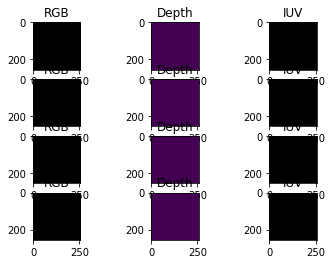

In [105]:
if verbosity > 1:
    batch_size = renderer_output['rgb_images'].shape[0]
    fig, axs = plt.subplots(batch_size, 3)
    for idx in range(batch_size):
        axs[idx, 0].imshow(renderer_output['rgb_images'][idx].detach().cpu())
        axs[idx, 0].set_title('RGB')
        axs[idx, 1].imshow(renderer_output['depth_images'][idx].detach().cpu())
        axs[idx, 1].set_title('Depth')
        axs[idx, 2].imshow(renderer_output['iuv_images'][idx].detach().cpu())
        axs[idx, 2].set_title('IUV')
    fig.show()

In [88]:
from pytorch3d.structures import Meshes
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# Debug Rendering

## Create Data Structures for Mesh and Texture

In [196]:
# each vertex has 3 texture features: i (body part index), u, v
textures_iuv = TexturesVertex(verts_features=pytorch3d_renderer.verts_iuv)
# increases number of vertices from SMPL vertex indexing (0 ... 6889) to DP vertex indexing (0 ... 7828)
vertices = target_vertices_for_rendering[:, pytorch3d_renderer.verts_map, :]
meshes_iuv = Meshes(
    verts=vertices,
    faces=pytorch3d_renderer.faces_densepose,
    textures=textures_iuv
)
# texture representation
textures_rgb = TexturesUV(
    maps=textures,
    faces_uvs=pytorch3d_renderer.faces_densepose,
    verts_uvs=pytorch3d_renderer.verts_uv_offset
)
meshes_rgb = Meshes(
    verts=vertices,
    faces=pytorch3d_renderer.faces_densepose,
    textures=textures_rgb
)
if verbosity > 1:
    print(f"Textures IUV: {textures_iuv._verts_features_padded.shape}")
    print("Meshes IUV:")
    print(f"    Vertices: {meshes_iuv._verts_padded.shape}")
    print(f"    Faces: {meshes_iuv._faces_padded.shape}")
    print("Textures RGB:")
    print(f"    Faces UVs: {textures_rgb._faces_uvs_padded.shape}") # for each face, indices into verts_uvs
    print(f"    Verts UVs: {textures_rgb._verts_uvs_padded.shape}") # per-vertex uv coordinates
    print(f"    Maps: {textures_rgb._maps_padded.shape}")
    print("Meshes RGB:")
    print(f"    Verts: {meshes_rgb._verts_padded.shape}")
    print(f"    Faces: {meshes_rgb._faces_padded.shape}")

Textures IUV: torch.Size([4, 7829, 3])
Meshes IUV:
    Vertices: torch.Size([4, 7829, 3])
    Faces: torch.Size([4, 13774, 3])
Textures RGB:
    Faces UVs: torch.Size([4, 13774, 3])
    Verts UVs: torch.Size([4, 7829, 2])
    Maps: torch.Size([4, 1200, 800, 3])
Meshes RGB:
    Verts: torch.Size([4, 7829, 3])
    Faces: torch.Size([4, 13774, 3])


Data structures look ok

## Rasterizer

In [203]:
pytorch3d_renderer.rasterizer?